## Please look at "FinalProject_RealTime" file to understand the followiong code

the code can take model and train it on multiple different computer while store the gradient graph as a count sketch and convert it back into gradient graph to make a full backward propogation algorithm and than disterbut the new step into the whole system.


In this excersize we train LSTM model,

Its pretty hard to train one so we just showing the concpet with count sketch

In [1]:
import random
import os
from os.path import join

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
localLossLs = []
disLossLs=[]
iterations = 30

class VaultBasedOnCountSketch:

    def __init__(self, w: int, d: int):

        data = [[0 for _ in range(w)] for _ in range(d)]

        self.data = data
        self.w = w
        self.d = d

        self.index_str_to_hashs = {}
        self.index_str_to_positive_negative = {}

    def store_number(self, tensor_id: int, i_index: int, j_index: int, number_to_store: float, fixed_size: int = 8):

        index_str = str(tensor_id) + "_" + str(i_index) + "_" + str(j_index)

        if index_str not in self.index_str_to_hashs:
            self.index_str_to_hashs[index_str] = [hash(index_str * (i + 1)) for i in range(self.d)]
            self.index_str_to_positive_negative[index_str] = [1 if hash("min_" + (index_str * (i + 1))) % 2 else -1 for
                                                              i in range(self.d)]

        hashes = self.index_str_to_hashs[index_str]
        positivity = self.index_str_to_positive_negative[index_str]

        number_to_store = int(number_to_store * (10 ** fixed_size))

        for i in range(self.d):
            _hash = hashes[i]
            _positive = positivity[i]

            index = _hash % self.w

            self.data[i][index] += number_to_store * _positive

    def get_count_of_line(self, tensor_id: int, i_index: int, j_index: int, fixed_size: int = 8):

        arr = []
        for row in range(self.d):

            index_str = str(tensor_id) + "_" + str(i_index) + "_" + str(j_index)
            hashes = self.index_str_to_hashs[index_str][row]
            positivity = self.index_str_to_positive_negative[index_str][row]

            col = hashes % self.w
            arr.append((float(self.data[row][col] * positivity) / (10 ** fixed_size)))

        arr.sort()

        return arr[len(arr) // 2]

    

def get_vault(gradient, w, d):
    
    vault = VaultBasedOnCountSketch(w, d)

    for index, tensor_params in enumerate(gradient):

        params = tensor_params.tolist()
        size = len(tensor_params.shape)

        if size == 2:
            for i in range(tensor_params.shape[0]):

                for j in range(tensor_params.shape[1]):
                    vault.store_number(index, i, j, params[i][j])
        else:
            for i in range(tensor_params.shape[0]):
                vault.store_number(index, i, 0, params[i])


    return vault


def set_gradient(vault, gradient):
    
    for index, tensor_params in enumerate(gradient):

        params = tensor_params.tolist()
        size = len(tensor_params.shape)

        if size == 2:
            for i in range(tensor_params.shape[0]):

                for j in range(tensor_params.shape[1]):
                    tensor_params[i][j] = vault.get_count_of_line(index, i, j)
        else:
            for i in range(tensor_params.shape[0]):
                tensor_params[i] = vault.get_count_of_line(index, i, 0, )

                

def length_of_weight(weights):

    to_return = 1
    for s in weights.shape:
        to_return *= s
    return to_return


def set_item(weights_list, index_of_weight, index_in_weight_list, weight, index_in_weight):

    shape_size = len(weight.shape)

    if shape_size == 4:

        index_0 = index_in_weight % weight.shape[0]
        index_in_weight //= weight.shape[0]

        index_1 = index_in_weight % weight.shape[1]
        index_in_weight //= weight.shape[1]

        index_2 = index_in_weight % weight.shape[2]
        index_in_weight //= weight.shape[2]

        index_3 = index_in_weight % weight.shape[3]
        index_in_weight //= weight.shape[3]

        weight[index_0][index_1][index_2][index_3] = weights_list[index_0][index_1][index_2][index_3]

    elif shape_size == 2:

        index_0 = index_in_weight % weight.shape[0]
        index_in_weight //= weight.shape[0]

        index_1 = index_in_weight % weight.shape[1]
        index_in_weight //= weight.shape[1]

        weight[index_0][index_1] = weights_list[index_0][index_1]

    elif shape_size == 1:

        weight[index_in_weight] = weights_list[index_in_weight]

    else:
        raise Exception("not supported !!!")

    return 0 


def insert_weights(weights_list: list, model):

    weight_list_index = 0
    index_of_weight = 0

    model_data = model.state_dict()

    _index = 0
    for key, weight in model_data.items():

        weight = np.zeros(weight.shape)
        weight_index = 0
        length = length_of_weight(weight)

        for index in range(length):

           next_weight_needed = set_item(weights_list[_index],index_of_weight, weight_list_index,weight, weight_index)
           weight_index += 1
           weight_list_index += 1
           if next_weight_needed:
                index_of_weight += 1
                weight_list_index = 0

        model_data[key].cpu().detach()
        model_data[key] = torch.tensor(weight).cuda()

        _index += 1

    model.load_state_dict(model_data)
    
def get_model_weight_data(model):
    
    to_return = []
    
    for item in model.parameters():
        to_return.append(np.copy(item.cpu().detach().numpy()))


    return to_return


def get_gradient(steped_model, real_model):
    
    to_return = []
    
    for i in range(len(real_model)):
        
        to_return.append(real_model[i] - steped_model[i])
        
    return to_return

def create_new_weight_based_on_gradient(model, gradient):
    
    to_return = []
    
    for i in range(len(model)):
        
        to_return.append(model[i] + gradient[i])
        
    return to_return
    
def multi_party_training(models, X, Y, number_of_computers):
    
    
    for iteration in range(iterations):
        
        vaults = []
        gradients = []
        total_loss = 0
        count = 0
        # get current model poarams state
        # in every starting iteration all models should have the same weights params
        current_model_data = get_model_weight_data(models[0])
        
        # all different servers learning on thier own on thier private data and creating a vault
        for computer_index in range(number_of_computers):
            
            x = X
            y = Y
            model = models[computer_index].cpu()
            
            optim_base = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
            mse = nn.MSELoss()

            # Learning step process
            _y = model(x)
            loss = mse(_y, y)
            optim_base.zero_grad()
            loss.backward()
            optim_base.step()
            total_loss += loss.cpu().detach().numpy()
            count += 1
            # get model state after one step
            steped_model_data = get_model_weight_data(model)

            # get gradient 
            gradient = get_gradient(current_model_data, steped_model_data)
            
            gradients.append(gradient)
            
            # create a vault
            vault = get_vault(gradient, w, d)
            
            # send my vault to the master server
            vaults.append(vault)
            
        # create new gradient based on all inputs
        
        for computer_index in range(number_of_computers):
            set_gradient(vaults[computer_index], gradients[computer_index])
        
        new_weight = create_new_weight_based_on_gradient(gradients[0], gradients[1])
        for computer_index in range(2, number_of_computers):
            new_weight = create_new_weight_based_on_gradient(new_weight, gradients[computer_index])
            
        for index in range(len(new_weight)):
            new_weight[index] /= number_of_computers
        
        # create new weight
        new_weight = create_new_weight_based_on_gradient(current_model_data, new_weight)
        
        # insert new weight to model
        for computer_index in range(number_of_computers):
            insert_weights(new_weight, models[computer_index])

        disLossLs.append(total_loss/count)
        print("Train iter " , iteration, " - loss ", total_loss/count)

  


In [2]:
def getLossFromTensor(t):
    strT = str(t)
    return float(strT.split('(')[1].split(',')[0])

## Data

trying to learning the following sentence from the previus sentence - downloaded the 5 first chapters of my favorite book

In [3]:

page = ""
for i in range(1, 6):
    with open("./page_" + str(i) + ".txt", "r",  encoding="utf8") as file:
        page += " " + file.read()


words = page.split(" ")
        

In [4]:
words_to_index = {}

for word in words:
    
    if word not in words_to_index:
        words_to_index[word] = len(words_to_index)

X = []
Y = []

for i in range(0, len(words) - 12, 6):
    
    x = []
    y = []
    
    for j in range(6):
        
        x.append(words_to_index[words[i + j]])
        y.append(words_to_index[words[i + j + 6]])
        
    X.append(x)
    Y.append(y)
    

## Model

In [5]:

EMBEDDING_DIM = 6
HIDDEN_DIM = 6

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, 1)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        return lstm_out


In [6]:
lstmTagger = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(words_to_index) + 1, len(words_to_index))

In [7]:

lstmTagger = lstmTagger.cuda()

X = torch.tensor(X)
Y = torch.tensor(Y)

X = X.cuda()
Y = Y.type(torch.float).cuda()

for iteration in range(iterations):
    
    optim_base = torch.optim.Adam(lstmTagger.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    mse = nn.MSELoss()
    
    total_loss = 0
    count = 0

    _Y = lstmTagger(X)
    
    loss = mse(_Y.view(-1, 1), Y.view(-1, 1))

    optim_base.zero_grad()
    loss.backward()
    optim_base.step()

    total_loss += loss.cpu().detach().numpy()
    count += 1
    
    #loss /= count
    localLossLs.append(getLossFromTensor(loss))   
    print("Train iter " , iteration, " - loss ", loss)


Train iter  0  - loss  tensor(962905.9375, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  1  - loss  tensor(962903., device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  2  - loss  tensor(962899.8750, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  3  - loss  tensor(962896.9375, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  4  - loss  tensor(962894., device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  5  - loss  tensor(962891.0625, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  6  - loss  tensor(962888.1250, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  7  - loss  tensor(962885.1875, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  8  - loss  tensor(962882.2500, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  9  - loss  tensor(962879.3125, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  10  - loss  tensor(962876.6250, device='cuda:0', grad_fn=<MseLossBackward>)
Train iter  11  - loss  tensor(962873.6875, device

Train by Sketch

In [8]:

number_of_computers = 10

models = [LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(words_to_index) + 1, len(words_to_index)) for i in range(number_of_computers)]

model_structure = models[0].state_dict()

models[0] = models[0].cuda()
for i in range(1, number_of_computers):
    models[i].load_state_dict(model_structure)
    

In [9]:
w = 1000
d = 25
X = X.cpu()
Y = Y.cpu()
multi_party_training(models, X, Y, number_of_computers)

c:\users\alon bar\appdata\local\programs\python\python39\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1628, 6])) that is different to the input size (torch.Size([1628, 1, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train iter  0  - loss  962896.5625
Train iter  1  - loss  962870.8125
Train iter  2  - loss  962844.0625
Train iter  3  - loss  962817.4375
Train iter  4  - loss  962789.75
Train iter  5  - loss  962759.5
Train iter  6  - loss  962728.875
Train iter  7  - loss  962697.3125
Train iter  8  - loss  962666.4375
Train iter  9  - loss  962633.625
Train iter  10  - loss  962600.0
Train iter  11  - loss  962564.5
Train iter  12  - loss  962527.75
Train iter  13  - loss  962490.3125
Train iter  14  - loss  962450.25
Train iter  15  - loss  962407.625
Train iter  16  - loss  962363.75
Train iter  17  - loss  962319.375
Train iter  18  - loss  962273.5
Train iter  19  - loss  962227.625
Train iter  20  - loss  962183.625
Train iter  21  - loss  962142.0625
Train iter  22  - loss  962102.5
Train iter  23  - loss  962065.3125
Train iter  24  - loss  962029.1875
Train iter  25  - loss  961993.6875
Train iter  26  - loss  961960.8125
Train iter  27  - loss  961929.1875
Train iter  28  - loss  961898.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
30


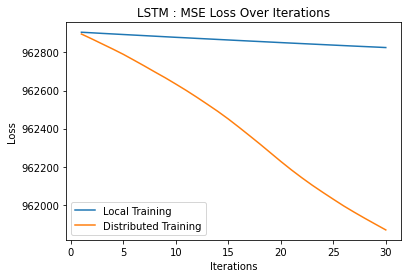

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
it = np.arange(1,iteration+2)
print(it)
print(len(localLossLs))
plt.plot(it,localLossLs,label = "Local Training")
plt.plot(it,disLossLs,label = "Distributed Training")
plt.title("LSTM : MSE Loss Over Iterations")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
